# XGBoost Regression

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('FE_data_18-19.csv', index_col=0)

# sort by date
df.sort_values(by='Date', inplace=True)

# make date the index
df.set_index('Date',inplace=True)

In [3]:
# split off end of 2019 as test set
test_size = df.shape[0] - 30
train, test = df.iloc[:test_size], df.iloc[test_size:]

# encode location
le = LabelEncoder()
le.fit(train['Location'])
train['Location'] = le.transform(train['Location'])
test['Location'] = le.transform(test['Location'])

X_train, X_test = train.drop(labels=['SsMean','logSsMean'], axis=1), test.drop(labels=['SsMean','logSsMean'], axis=1)
y_train, y_test = train.logSsMean, test.logSsMean

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xg = xgb.XGBRegressor()
xg.fit(X_train,y_train)

<ipython-input-3-377811fac0cd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Location'] = le.transform(train['Location'])
<ipython-input-3-377811fac0cd>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Location'] = le.transform(test['Location'])


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

Training acc: 0.9999790209819981
Testing acc: 0.31347594758714203
Mean squared error:  2.277854213870371
MAE:  1.1828130489421314


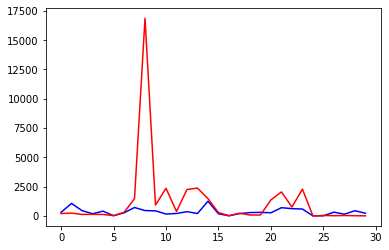

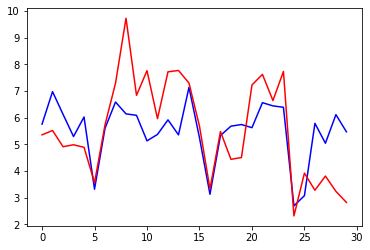

In [4]:
y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', score)
train_pred = xg.predict(X_train)

mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: ', mae)

plt.plot(np.exp(y_pred), c='b')
plt.plot(np.exp(y_test.values), c='r')
plt.show()

plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

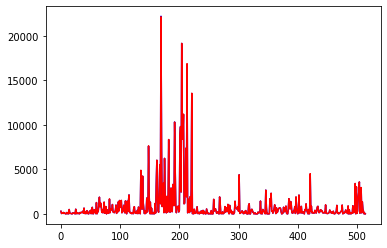

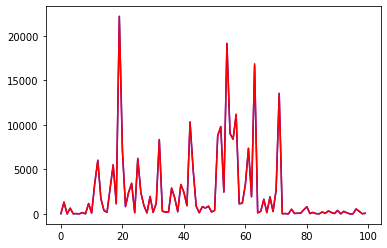

In [5]:
# plot training
plt.plot(np.exp(train_pred), c='b')
plt.plot(np.exp(y_train.values), c='r')
plt.show()

# close up
plt.plot(np.exp(train_pred)[150:250], c='b')
plt.plot(np.exp(y_train.values)[150:250], c='r')
plt.show()

In [6]:
def classify(data):
    if data < 60:
        return 0
    elif data < 250:
        return 1
    elif data < 500:
        return 2
    elif data >= 500:
        return 3
    
def from_log(data):
    return np.exp(data)

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [8]:
test_result = pd.DataFrame()
test_result['log_y_pred'] = y_pred
test_result['y_pred'] = test_result.log_y_pred.apply(from_log)
test_result['pred_label'] = test_result.y_pred.apply(classify)
test_result['y'] = y_test.values
test_result['y_log'] = test_result.y.apply(from_log)
test_result['true_label'] = test_result.y_log.apply(classify)

In [9]:
cr = classification_report(test_result.true_label, test_result.pred_label)
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.25      0.29      0.27         7
           2       0.08      0.25      0.12         4
           3       0.83      0.45      0.59        11

    accuracy                           0.40        30
   macro avg       0.54      0.37      0.41        30
weighted avg       0.64      0.40      0.47        30



Confusion matrix, without normalization
[[4 2 2 0]
 [0 2 5 0]
 [0 2 1 1]
 [0 2 4 5]]


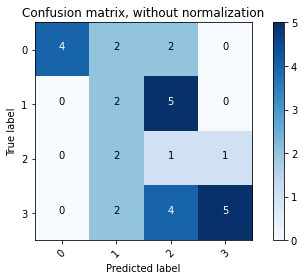

In [10]:
cm = confusion_matrix(test_result.true_label, test_result.pred_label)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')

### Cross val grid search

In [45]:
# split off end of 2019 as test set
test_size = df.shape[0] - 30
train, test = df.iloc[:test_size], df.iloc[test_size:]

# encode location
le = LabelEncoder()
le.fit(train['Location'])
train['Location'] = le.transform(train['Location'])
test['Location'] = le.transform(test['Location'])

X_train, X_test = train.drop(labels=['SsMean','logSsMean'], axis=1), test.drop(labels=['SsMean','logSsMean'], axis=1)
y_train, y_test = train.logSsMean, test.logSsMean

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<ipython-input-45-58e91533fc91>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Location'] = le.transform(train['Location'])
<ipython-input-45-58e91533fc91>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Location'] = le.transform(test['Location'])


In [46]:
from sklearn.model_selection import GridSearchCV

# ignore params for now and just see if kfolds helps with overfitting
params = {

}

kfolds = 5

clf = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=params, cv=kfolds)

Training acc: 0.9791718247770158
Testing acc: 0.30886427663358507
Train Mean squared error:  0.0694553435438543
Test Mean squared error:  2.2931555191598556
Train MAE:  0.19077914892963113
Test MAE:  1.1115080526052492


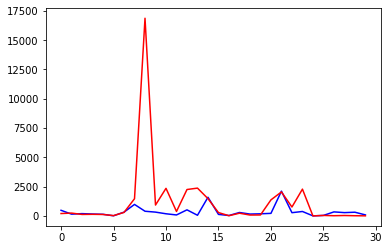

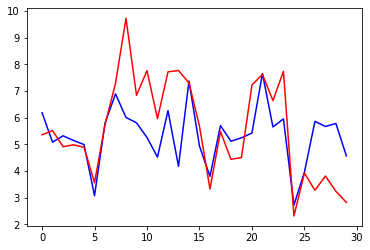

In [47]:
y_pred = xg.predict(X_test)
train_score = xg.score(X_train, y_train.values)
test_score = xg.score(X_test, y_test.values)
print('Training acc:', train_score)
print('Testing acc:', test_score)
train_pred = xg.predict(X_train)

train_mse = mean_squared_error(y_train, train_pred)
print('Train Mean squared error: ', train_mse)
test_mse = mean_squared_error(y_test, y_pred)
print('Test Mean squared error: ', test_mse)

train_mae = mean_absolute_error(y_train, train_pred)
print('Train MAE: ', train_mae)
test_mae = mean_absolute_error(y_test, y_pred)
print('Test MAE: ', test_mae)

plt.plot(np.exp(y_pred), c='b')
plt.plot(np.exp(y_test.values), c='r')
plt.show()

plt.plot(y_pred, c='b')
plt.plot(y_test.values, c='r')
plt.show()

In [42]:
def classify(data):
    if data < 300:
        return 0
    elif data >= 300:
        return 1

In [43]:
test_result = pd.DataFrame()
test_result['log_y_pred'] = y_pred
test_result['y_pred'] = test_result.log_y_pred.apply(from_log)
test_result['pred_label'] = test_result.y_pred.apply(classify)
test_result['y'] = y_test.values
test_result['y_log'] = test_result.y.apply(from_log)
test_result['true_label'] = test_result.y_log.apply(classify)

cr = classification_report(test_result.true_label, test_result.pred_label)
print(cr)

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.67      0.62      0.64        13

    accuracy                           0.70        30
   macro avg       0.69      0.69      0.69        30
weighted avg       0.70      0.70      0.70        30



Confusion matrix, without normalization
[[13  4]
 [ 5  8]]


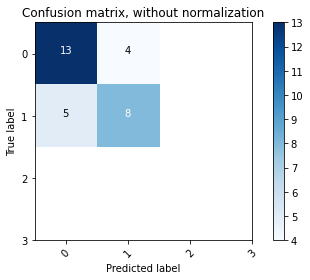

In [44]:
cm = confusion_matrix(test_result.true_label, test_result.pred_label)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=[0,1,2,3],
                      title='Confusion matrix, without normalization')